In [ ]:
from examples.paper.initialize import *
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score

# Read in Data

In [4]:
data_name = 'german'
data_file = data_dir / ('%s_processed.csv' % data_name)
output_dir = results_dir /  data_name

## load and process data
data_df = pd.read_csv(data_file).reset_index(drop=True)
# german_df = german_df.assign(isMale=lambda df: (df['Gender']=='Male').astype(int))#.drop(['PurposeOfLoan', 'Gender', 'OtherLoansAtStore'], axis=1)
y = data_df['GoodCustomer']
X = (data_df.drop('GoodCustomer', axis=1)
     .drop(['PurposeOfLoan', 'Gender', 'OtherLoansAtStore'], axis=1))

# Train classifier

In [6]:
## Train and generate AUCs
## grid search
clf = LogisticRegression(max_iter=1000, solver='lbfgs')
grid = GridSearchCV(
        clf, param_grid={'C': np.logspace(-4, 3)},
        cv=10,
        scoring='roc_auc',
        return_train_score=True
        )
grid.fit(X, y)
clf = grid.best_estimator_

# Create Actionset

In [5]:
## set up actionset
gender_weight = data_df.assign(c = 1).groupby('Gender')['c'].transform(lambda s: s * 1. / len(s))
X_gender_balanced = X.sample(n = len(X)*3, replace=True, weights=gender_weight)
action_set = ActionSet(X = X_gender_balanced)
action_set['Age'].mutable = False
action_set['Single'].mutable = False
action_set['JobClassIsSkilled'].mutable = False
action_set['ForeignWorker'].mutable = False
action_set['OwnsHouse'].mutable = False
action_set['RentsHouse'].mutable = False
action_set['CriticalAccountOrLoansElsewhere'].step_direction = -1
action_set['CheckingAccountBalance_geq_0'].step_direction = 1

# Run Audit

In [10]:
# median score
np.median(clf.predict_proba(X)[:, 1])

0.7204080942839757

In [11]:
# cache classifier
coefficients = clf.coef_[0]
intercept = clf.intercept_[0]
action_set.align(coefficients=coefficients)

# audit
p = .72 ## for now we'll set this to the median score, but we could set this to any threshold we want.
auditor = RecourseAuditor(
    action_set,
    coefficients = coefficients,
    intercept = intercept - (np.log(p / (1. - p))),
)
audit_results = auditor.audit(X = X)

# Visualize

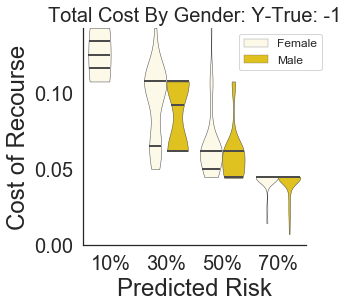

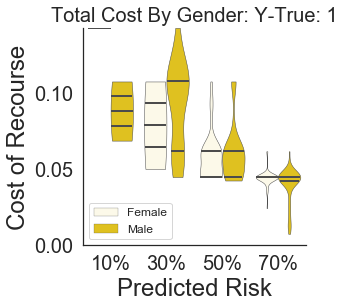

In [17]:
scores = pd.Series(clf.predict_proba(X)[:, 1])
matching_df = pd.concat([
    data_df[['GoodCustomer', 'Gender']],
    audit_results[['cost']],
    scores.to_frame('y_pred')
    ], axis=1).replace(np.inf, np.nan).dropna()


####### Matching 2: Control for Y=+/- 1
matching_df['y_pred_bin'] = pd.cut(
    matching_df['y_pred'],
    bins=np.arange(0, .9, .2)
)

bins = matching_df['y_pred_bin'].unique()

max_cost = matching_df['cost'].max()
plt.rc("font", size=20)
for y_true in [-1, 1]:
    plt.figure(figsize=(4, 4))
    ax = sns.violinplot(
        x='y_pred_bin',  y='cost', hue='Gender',
        data=matching_df.loc[lambda df: df['GoodCustomer'] == y_true].sort_values('Gender'),
        linewidth = 0.5, cut=0, background='white',
        scale = 'width', color="gold",  inner = 'quartile'
    )
    ax.set_xticklabels(["10%", "30%", "50%", "70%"])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylim((0, max_cost))
    plt.title('Total Cost By Gender: Y-True: %d' % y_true, fontsize=20)
    plt.ylabel('Cost of Recourse')
    plt.xlabel('Predicted Risk' )

    if y_true == -1:
        plt.legend(fontsize=12., loc='upper right', bbox_to_anchor=(1.1, 1))
    else:
        plt.legend(fontsize=12., loc='lower left')#, bbox_to_anchor=(1.1, 1))
    for l in ax.lines:
        l.set_linewidth(2.)
        l.set_linestyle('-')
        l.set_solid_capstyle('butt')

    plt.show() 

# Generate Flipsets

In [26]:
from IPython.display import HTML

In [ ]:
# ### get flipset
gender = "Male"
individuals = (matching_df
    .loc[lambda df: df['Gender'] == gender]
    .loc[lambda df: df['y_pred'] < .3]
    .loc[lambda df: df['y_pred'] > .1]
    .loc[lambda df: df['GoodCustomer'] == 1]
    )
i = individuals.index[1]

fb = Flipset(
    x = X.loc[i].values, 
    action_set = action_set, 
    coefficients = coefficients,
    intercept = intercept - (np.log(p / (1. - p))),
)
fb.populate(enumeration_type = 'distinct_subsets', total_items = 6)

In [58]:
HTML(fb.to_html())

In [ ]:
gender = 'Female'
individuals = (matching_df
    .loc[lambda df: df['Gender'] == gender]
    .loc[lambda df: df['y_pred'] < .3]
    .loc[lambda df: df['y_pred'] > .1]
    .loc[lambda df: df['GoodCustomer'] == 1]
    )
i = individuals.index[0]

fb = Flipset(
    x = X.loc[i].values, 
    action_set = action_set, 
    coefficients = coefficients,
    intercept = intercept - (np.log(p / (1. - p))),
)
fb.populate(enumeration_type = 'distinct_subsets', total_items = 6)

In [60]:
HTML(fb.to_html())